# Criticality in the Cortex

## Imports

In [2]:
'''Setup notebook environment -q flag suppresses output, if you want to see it, remove the -q flag'''
%pip install -r requirements.txt -q
from utils.plotting_utils import *
from utils.data_utils import *
from utils.utils import *
from branching import BranchingNeurons
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import powerlaw
import multiprocessing as mp
from functools import partial
from tqdm.notebook import tqdm
from cellular_automata import CA
from collections import Counter
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Note: you may need to restart the kernel to use updated packages.


## Branching model

The first section of this notebook will be investigating the behavior of a branching model. This model is a simple branching process, where each neuron has a probability of firing, and if it does, it will fire to a number of other neurons. This is a simple model of the branching of neurons in the cortex.

In [ ]:
# !! Files should be available in the data folder, if not, run the code below. It may take a while !!
file = 'data/branching_data_densities.csv'
if not os.path.exists(file):
    for branching_ratio in tqdm(np.logspace(np.log10(0.5), np.log10(5), 20)):
        for i in [0,1,3,5]:
            kwargs = {
                'N': 100,
                'max_neighbors': 28,
                'cooldown': i,
                'branching_ratio': branching_ratio,
                'visual': False,
            }
            data = simulate(BranchingNeurons, n_runs=10, duration=10000, **kwargs)
            write_data(data, file)


file = 'data/branching_data_final.csv'
if not os.path.exists(file):
    for branching_ratio in tqdm(np.logspace(np.log10(0.5), np.log10(5), 20)):
        kwargs = {
            'N': 2500,
            'max_neighbors': 28,
            'branching_ratio': branching_ratio,
            'visual': False,
        }
        data = simulate(BranchingNeurons, n_runs=10, duration=10000, **kwargs)
        write_data(data, file)

In [7]:
data = pd.read_csv('data/branching_data_final.csv', header=0, index_col=0)
data['mean_density'] = data['density'].apply(float)
data['evalanche_duration'] = data['evalanche_duration'].apply(str_to_list)
data['evalanche_size'] = data['evalanche_size'].apply(str_to_list)

data['density_duration'] = data.apply(lambda x: get_density(x['evalanche_duration'])[0], axis=1)
data['density_size'] = data.apply(lambda x: get_density(x['evalanche_size'])[0], axis=1)
data['values_duration'] = data.apply(lambda x: get_density(x['evalanche_duration'])[1], axis=1)
data['values_size'] = data.apply(lambda x: get_density(x['evalanche_size'])[1], axis=1)


grouped_branching = data.groupby('branching_ratio').mean(numeric_only=True)
critical_point = closest_index_to_value(grouped_branching.index, 1)
critical_data = grouped_branching.loc[grouped_branching.index == grouped_branching.index[critical_point]]

### Behavior over time for different branching ratios
We can see that for different branching ratios, the behavior of the system changes. For a branching ratio of 1.1 (because of system size we correct the branching ratio upward a little bit), the system is at a critical point, and the activations quickly increase but die out after a period of activiy. For a branching ratio of 0.8, the system will die out, and for a branching ratio of 2, the system tend to chaos.


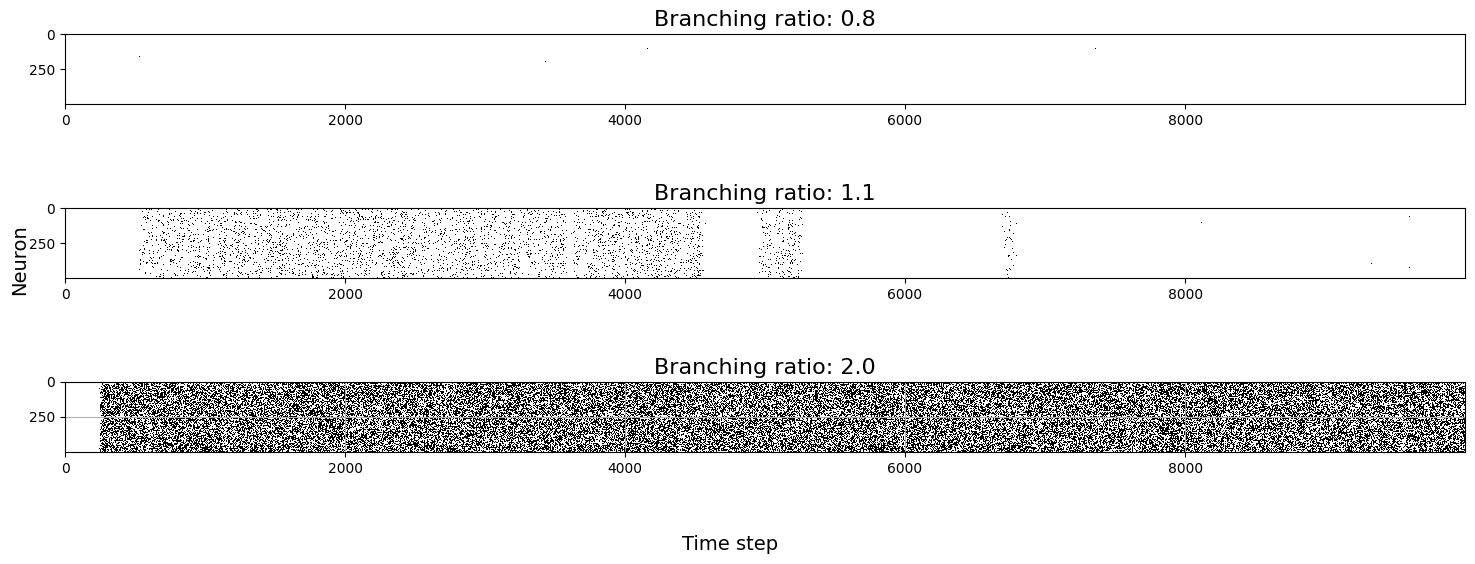

In [8]:
kwargs = {
    'N': 500,
    'max_neighbors': 28,
    'branching_ratio': None,
    'visual': False,
}
plot_activity_per_time_step(10000, **kwargs)

### Comparing the emperical branching ratio
When we manually calculate the branching ratio, we find that the branching ratio does not the same as the one we set. This is because the branching ratio is a function of the system size, and the system size is not large enough to get a good estimate of the branching ratio. This is a common problem in the study of criticality in the cortex, and is known as the "finite size effect".



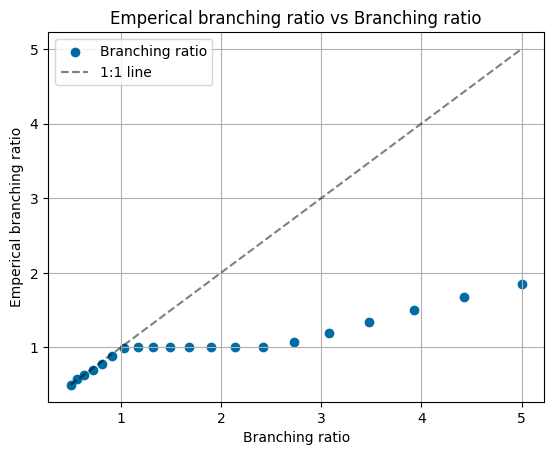

In [9]:

plot_emperical_branching_ratio(grouped_branching)

### Phase transition
When plotting the mean activity of the system over time, we can see that the system goes through a phase transition at a branching ratio of 1. This is a critical point, and the system will go from a state of low activity to a state of high activity. This is a phase transition, and is a common feature of critical systems.

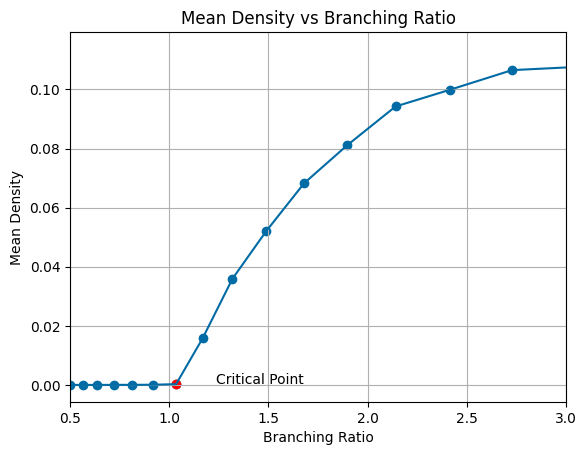

In [10]:
plot_mean_density_vs_branching_ratio(grouped_branching, critical_point)

### A note on the activity
We noticed the mean activity of the system does not approach 1, we suspect this might also be because the system size is not large enough to get a good estimate of the mean activity. We also suspected the refractory period of the neurons might also affect the mean activity of the system, but looking at the figure below comparing the mean activity of the system for different refractory periods, we can see that the refractory period only decreases the mean activity of the system, and does not affect the phase transition.


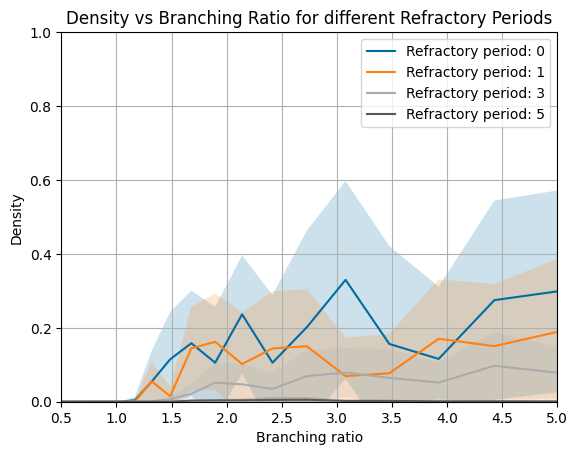

In [11]:
data_cooldowns = pd.read_csv('data/branching_data_densities.csv', header=0, index_col=0)
grouped_cooldowns = data_cooldowns.groupby(['cooldown', 'branching_ratio']).agg({'density': ['mean', 'std']})


plot_phase_transition_cooldowns(grouped_cooldowns)

### Avalanche distributions
Below we plot the avalanche distributions for their size and duration. In both we notice no statistically significant results for the power law distribution, which is a common feature of critical systems. Although we do note that the figures visually look very much like a power law distribution. We also see that around the branching ratio these distributions become more power law like.

/Users/eva/anaconda3/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/Users/eva/anaconda3/lib/python3.11/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for t

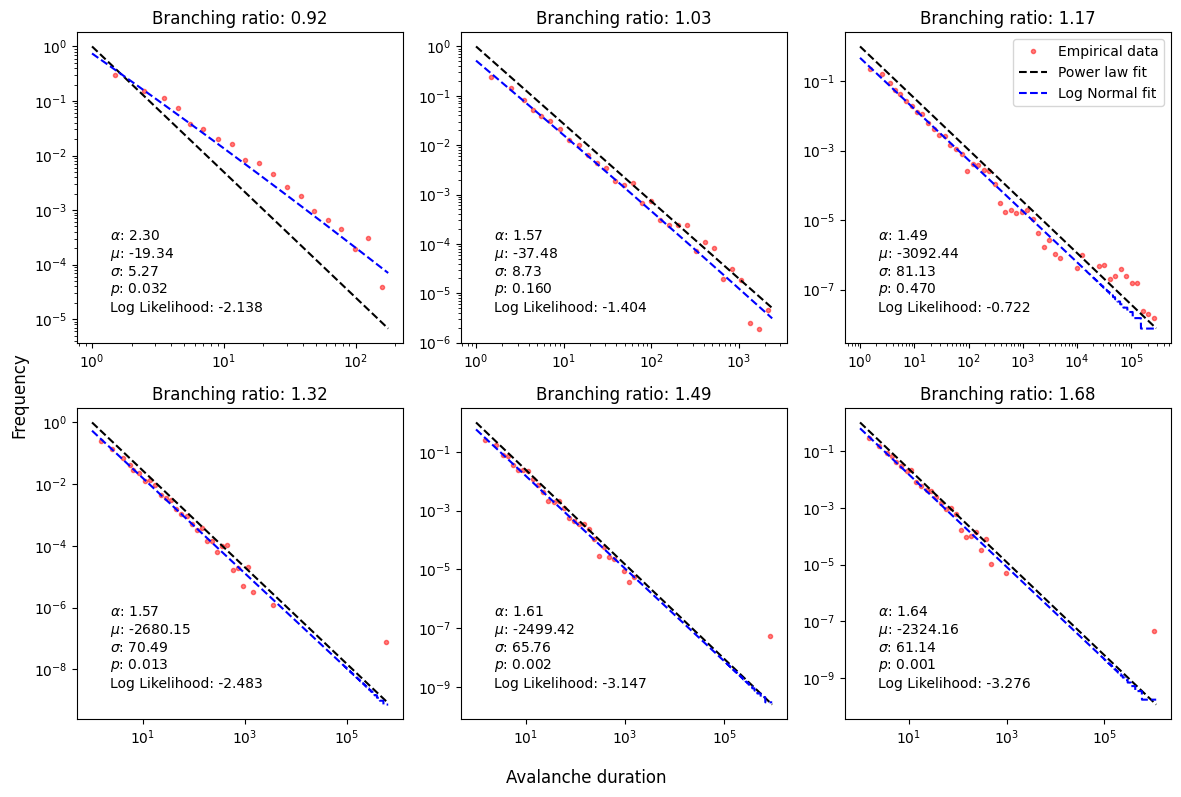

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

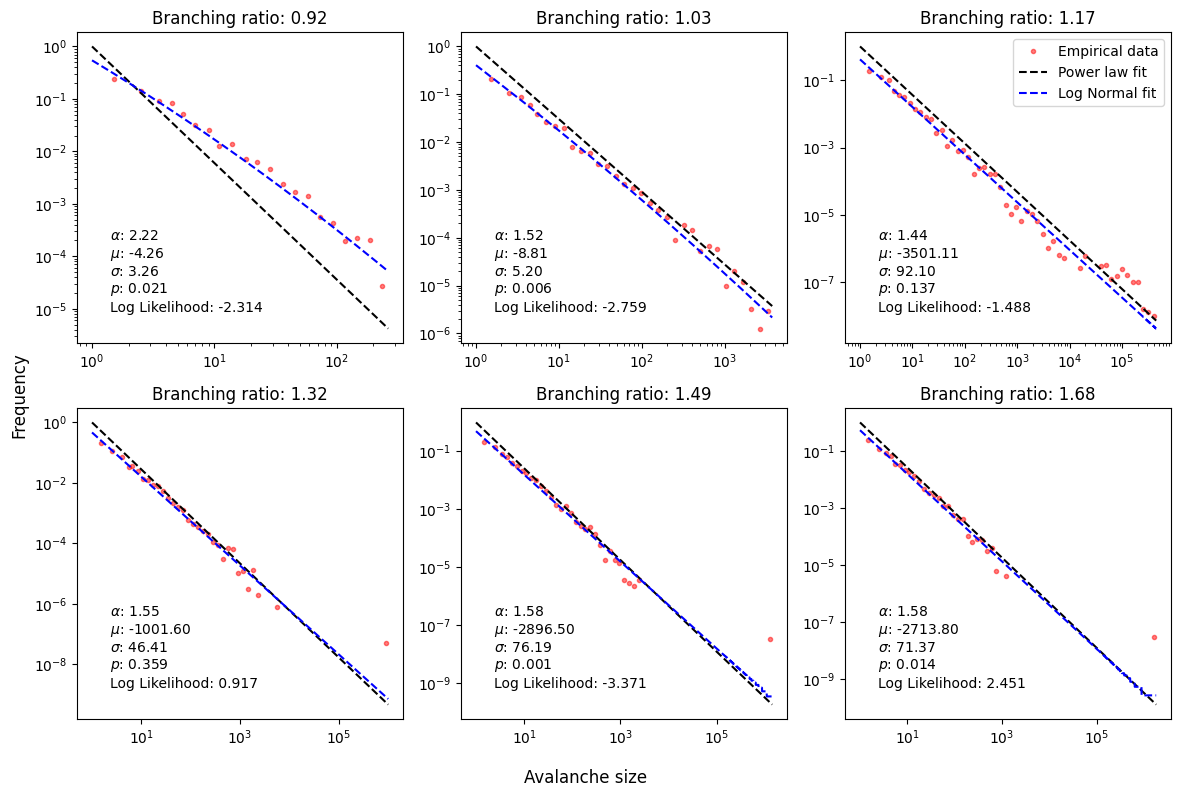

In [12]:
data['avalanche_duration'] = data['evalanche_duration']
data['avalanche_size'] = data['evalanche_size']
loglog_plotting("avalanche_duration", data, grouped_branching)
loglog_plotting("avalanche_size", data, grouped_branching)

In [ ]:
loglog_plotting_size_duration(['evalanche_size', 'evalanche_duration'], data, grouped_branching)

### Information flow
> We will be investigating the following information transfer properties of the branching model:
> 1. The dynamic range of the information transfer between the input and the output layer 
> 2. The susceptibility of the information transfer, being measured as the total variance between the input and the output layer

### Information transfer between the input and the output layer
The following code will be investigating the information transfer between the input and the output layer. We will be looking at the mutual information between the input and the output layer, and how it changes with the branching ratio. We will also be looking at the information transfer between the input and the output layer, and how it changes with the branching ratio.

In [13]:

branching_ratios = np.linspace(0.2, 3, 15)
input_nums = list(range(1, 100, 2))
mutual_infos = []
dynamic_ranges = []
susceptibilities = []
susceptibilities_error = []

for branching_ratio in branching_ratios:
    kwargs = {
        'N': 100,
        'max_neighbors': 8,
        'branching_ratio': branching_ratio,
        'cooldown': 0,
        'visual': False,
    }
    sim = BranchingNeurons(**kwargs)
    output_nums = []
    sus_list = []

    for input_num in input_nums:
        spike_history = []
        for _ in range(10):
            running_average = []
            sim.reset()

            neurons_to_activate = np.random.choice(sim.neurons, input_num, replace=False)

            assert len(neurons_to_activate) == input_num

            for neuron in neurons_to_activate:
                neuron.active = True
                sim.active.append(neuron)

            for i in range(10):
                sim.run(1, random_adding=False)
                running_average.append(sum([neuron.active for neuron in sim.neurons]))

            spike_history.append(np.mean(running_average))

        output_nums.append(spike_history[-1])
        sus_list.append(susceptibility(spike_history, 100))
    mutual_infos.append(mutual_info(input_nums, output_nums))
    dynamic_ranges.append(dynamic_range(output_nums))
    susceptibilities.append(np.mean(sus_list))
    susceptibilities_error.append(np.std(sus_list)/np.sqrt(len(sus_list)))

Here we can see that as the branching ratio increase the information transfer between the input and the output layer increases. We can also see the susceptibility peak around the critical point.

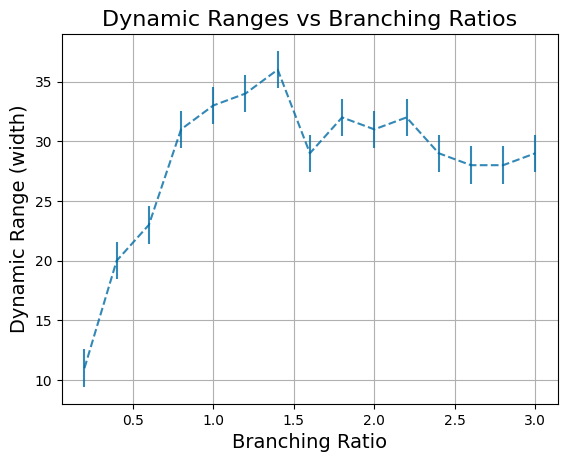

In [14]:
dynamic_range_plot(dynamic_ranges, branching_ratios)

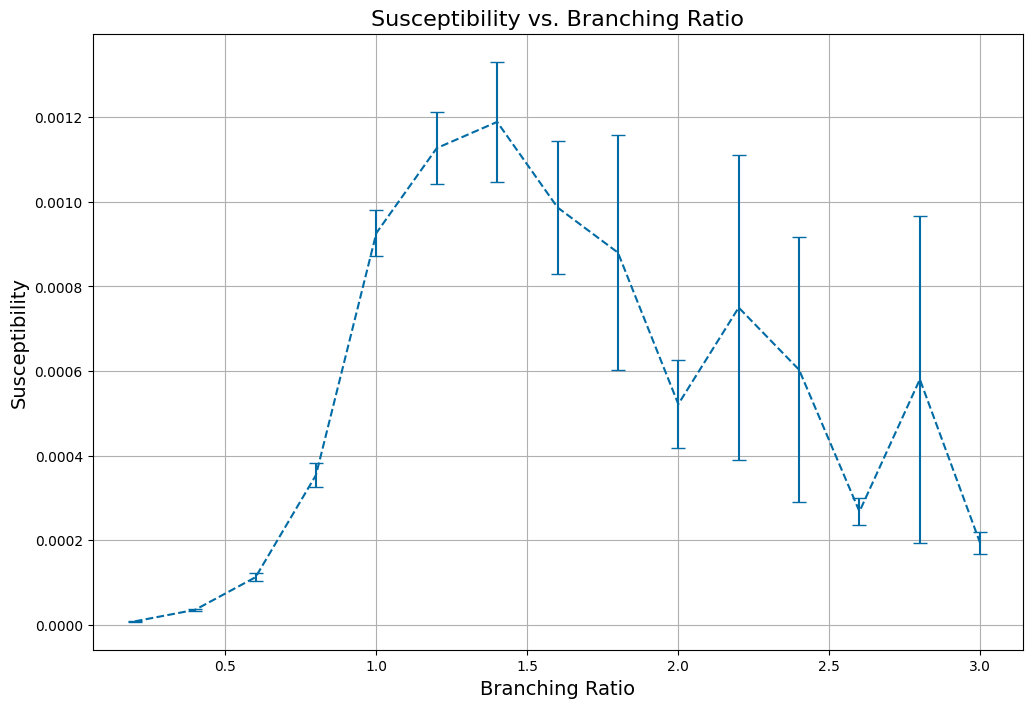

In [15]:
susceptibility_plot(susceptibilities, susceptibilities_error, branching_ratios)

## CA model

#### Write data
> Running this part of the codes may take a while. You could just skip this part and go straight to the next part for drawing.

##### df: index, spikes_total, spikes_input, spikes_neighbours

For different patterns:

In [ ]:
settings1 = [
    {"name": "round_spiral", "params": {"threshold": 4, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}},
    {"name": "pulse_wave", "params": {"threshold": 5, "refractory_period": 3, "probability_of_spontaneous_activity": 0.03, "max_distance": 3, "random_connection": False}},
    {"name": "synchronous", "params": {"threshold": 3, "refractory_period": 5, "probability_of_spontaneous_activity": 0.015, "max_distance": 2.5, "random_connection": True}},
    {"name": "oscillatory", "params": {"threshold": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}},
    {"name": "repeating", "params": {"threshold": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": True}},
    {"name": "random", "params": {"threshold": 5, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}}]

In [ ]:
# Data collection to csv in df: spikes_input, spikes_neighbours, spikes_total per time step
for setting in settings1:
    ca = CA(grid_size=[50, 50], **setting['params'])
    ca.run(10000)
    path = f"data/spikes_CA_{setting['name']}.csv"
    ca.write_data(path)

In [ ]:
# see what's the pattern like for different patterns
paths = [f"data/spikes_CA_{setting['name']}.csv" for setting in settings1]
for path in paths:
    df = load_data_csv(path)
    sigma = branching_prameter(df)
    print(path, sigma)


For more parameters settings:

##### df: avalanche_size, avalanche_duration

This is used to store raster data, which is not used later.

In [ ]:
for setting in settings2:
    ca = CA(grid_size=[50, 50], **setting['params'])
    path = f"data/spikes_CA_avalanche/spikes_CA_{setting['name']}.csv"
    ca.collect_raster_data(10000, path) # This function: collect raster data was once used to collect raster data in csv files.

This is used to store raster data for different patterns, which is also used plot spike activity figures.

In [ ]:
for setting in settings1:
    ca = CA(grid_size=[20, 20], ** setting['params'])
    path = f"data/spikes_CA_avalanche_grid/spikes_CA_{setting['name']}.csv"
    df = ca.collect_raster_data(5000)
    df.to_csv(path)

This is used to store avalanche data, which is also used to plot power law distributions later.

In [ ]:
settings3 = [{"name": f"ref{ref}thresh{thresh}p{p}", 
            "params": {"threshold": thresh, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": False}}
            for ref in range(2, 8) for thresh in range(2, 8) for p in [0.015, 0.02, 0.025]]
paths_avalanche = []
settings4 = []
for setting in settings3:
    ca = CA(grid_size=[20, 20], **setting['params'])
    df_raster = ca.collect_raster_data(3000)
    df = raster_to_basic(df_raster)
    sigma = branching_prameter(df)
    print(sigma)
    if(abs(sigma-1) < 0.05):
        settings4.append(setting)

In [ ]:
if(abs(branching_prameter(df)-1) < 0.05):
        df_transmission = raster_to_transmission(df_raster)
        avalanche = transmission_to_avalanche(df_transmission)
        avalanche_df = avalanche_to_statistics(avalanche)
        avalanche_df.to_csv(path, index=True)    
        paths_avalanche.append(path)
        print("Data written to:", path)

### Average Spike Density vs. Branching Ratio m

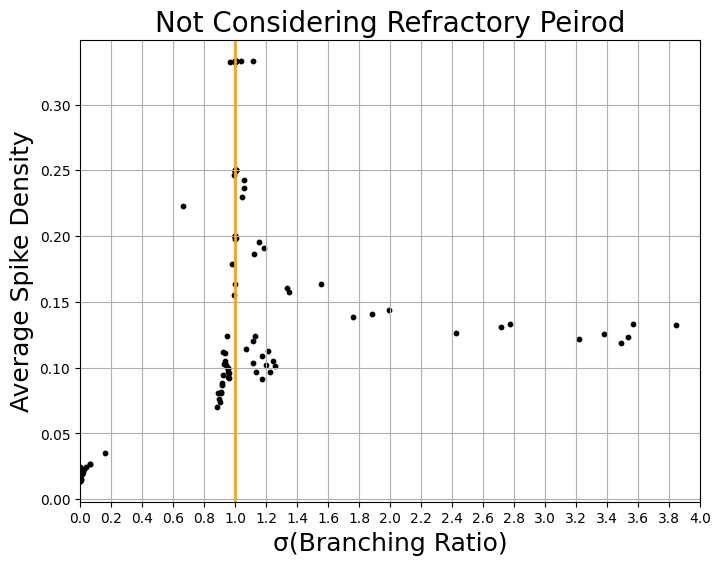

In [3]:
# Plot avg_spike_density vs. m
settings2 = [{"name": f"ref{ref}thresh{thresh}p{p}r{False}", 
            "params": {"threshold": thresh, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": False}}
            for ref in range(1, 8) for thresh in range(1, 7) for p in [0.015,0.02,0.025]]
# The write data is neglected in this ipynb for clarification. It's similar to what we did to the settings1.
paths = [f"data/spikes_CA_ref_thresh/spikes_CA_{setting['name']}.csv" for setting in settings2]
size = 50
spike_density_plot(paths, size)

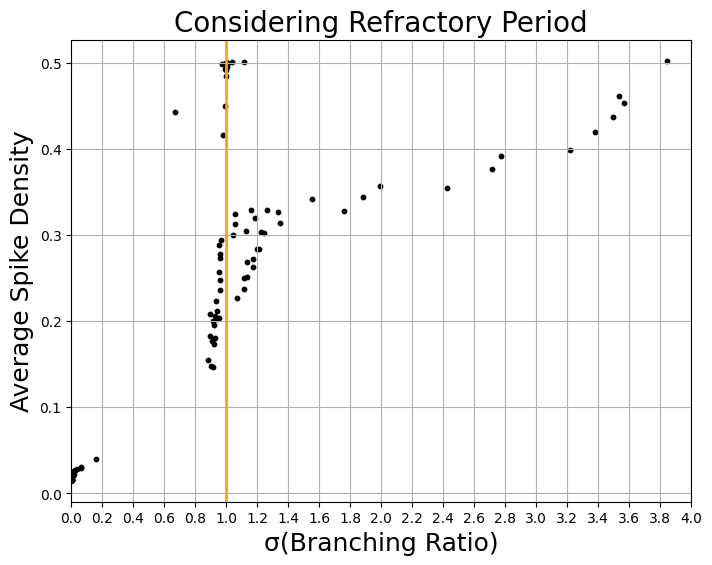

In [4]:
# Plot avg_spike_density vs. m considering refractory period 
settings2 = [{"name": f"ref{ref}thresh{thresh}p{p}r{False}", 
            "params": {"threshold": thresh, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": False}}
            for ref in range(1, 8) for thresh in range(1, 7) for p in [0.015,0.02,0.025]]
# The write data is neglected in this ipynb for clarification. It's similar to what we did to the settings1.
paths = [f"data/spikes_CA_ref_thresh/spikes_CA_{setting['name']}.csv" for setting in settings2]
refs = [setting['params']['refractory_period'] for setting in settings2]
size = 50
ref_spike_density_plot(paths, size, refs)

### Avalanche size/duration distribution (distinguishing origins)

In [ ]:
avalanches = []
# This for loop takes a long time to run.
# You can just run the third cell to load the data from the csv files.
for i in range(20):
    # This is a parameter setting we selcted which sigma is near 1.
    ca = CA(grid_size=[50, 50], refractory_period=3,threshold=2,probability_of_spontaneous_activity=0.02,max_distance=3,random_connection=False)
    raster_df = ca.collect_raster_data(1000)
    df = raster_to_basic(raster_df)
    df_transmission = raster_to_transmission(raster_df)
    avalanche = transmission_to_avalanche(df_transmission)
    avalanche_df = avalanche_to_statistics(avalanche)
    avalanches.append(avalanche)
all_avalanches = [item for sublist in avalanches for item in sublist]




In [ ]:
# writing data
avalanche_df = avalanche_to_statistics(all_avalanches)
avalanche_df.to_csv("data/avalanche_powerlaw_df.csv", index=True)
avalanches_by_length = defaultdict(list)
for av in all_avalanches:
    avalanches_by_length[len(av)].append(av)
mean_activities = {length: np.mean(np.array(avs), axis=0) for length, avs in avalanches_by_length.items()}

Calculating best minimal value for power law fit
/Users/eva/anaconda3/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/Users/eva/anaconda3/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


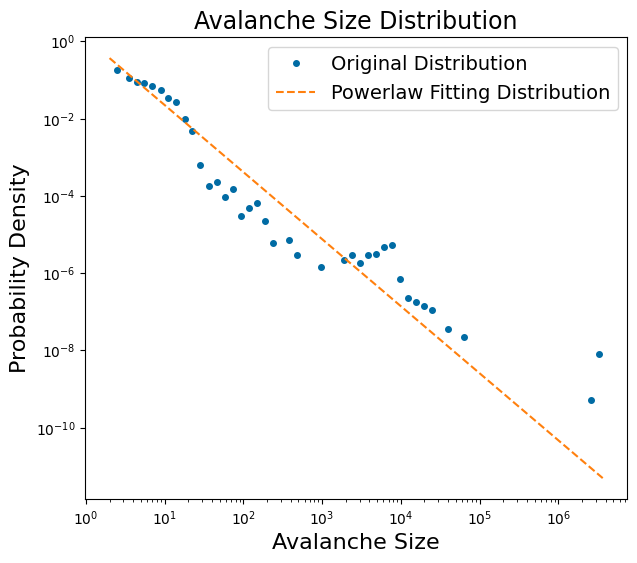

Tau (τ) - Power-law exponent: 1.735105657225038


In [4]:
# Run this cell to get plot directly
df = load_data_csv("data/avalanche_powerlaw_df.csv")
avalanche_sizes = df['size'].tolist()
fit = powerlaw.Fit(avalanche_sizes)
fig, ax = plt.subplots(figsize=(7, 6))
plt.style.use('tableau-colorblind10') 

fit.plot_pdf(ax=ax,linestyle='None', marker='o', markersize=4, label='Original Distribution')
fit.power_law.plot_pdf(linestyle='--', ax=ax, label='Powerlaw Fitting Distribution')
plt.legend(fontsize=14)
plt.xlabel("Avalanche Size", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.title("Avalanche Size Distribution", fontsize=17)
plt.show()
print('Tau (τ) - Power-law exponent:', fit.power_law.alpha)


### Grid activity

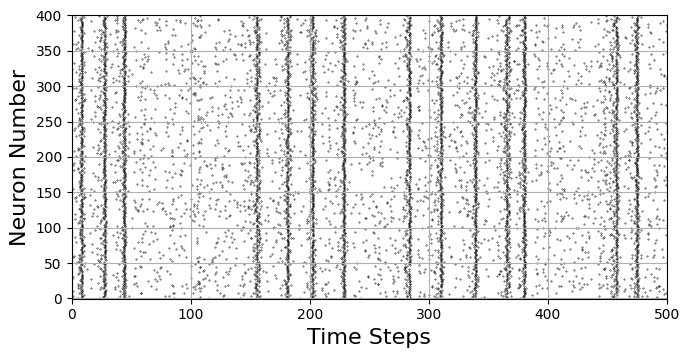

In [3]:
paths = [f"data/spikes_CA_avalanche_grid/spikes_CA_synchronous.csv"]# Change the path to get diffenrent activity plots
spike_activity_plot(paths, 20)

### Spike Density vs timestep

In [ ]:
settings3 = [{"name": f"ref{ref}thresh{t}p{p}r{r}", 
            "params": {"threshold": t, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": r}}
            for ref in range(1, 8) for t in range(1, 8) for p in [0.015, 0.02, 0.025] for r in [False, True]]
paths = [f"data/spikes_CA_ref_thresh/spikes_CA_{setting['name']}.csv" for setting in settings3]
for path in paths:
    df = pd.read_csv(path)
    r = branching_prameter(df)
    if(abs(r - 1) < 0.05):
        print("paths: ", path)
        print(r)

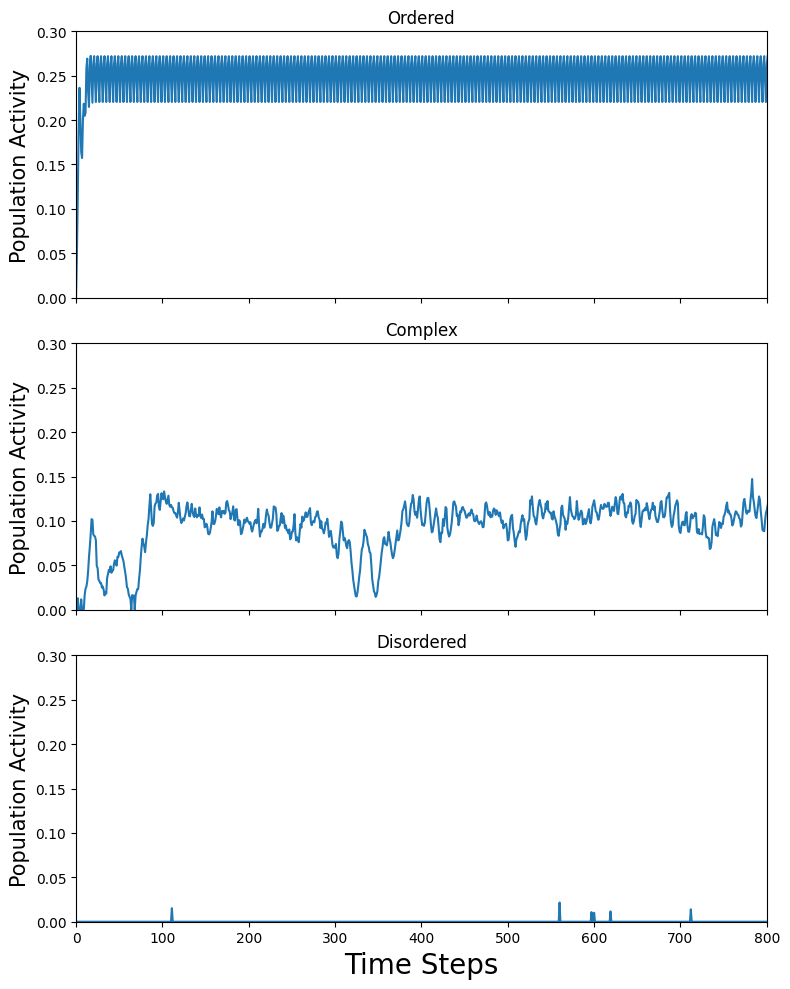

In [2]:
paths = ["data/spikes_CA_ref_thresh/spikes_CA_ref2thresh3p0.02rFalse.csv",
         "data/spikes_CA_ref_thresh/spikes_CA_ref4thresh4p0.015rFalse.csv",
         "data/spikes_CA_ref_thresh/spikes_CA_ref6thresh6p0.015rTrue.csv"]
size = 50
grid_activity_timestep(paths, 50)

### Scale-free Property

In [2]:
avalanches = []
# This loop takes a long time to run. 
# To get the result figure we showed in the presentation, you can just run the third block in this section.
for i in range(10): 
    ca = CA(grid_size=[50, 50], refractory_period=3,threshold=2,probability_of_spontaneous_activity=0.02,max_distance=3,random_connection=False)
    raster_df = ca.collect_raster_data(1000)
    df = raster_to_basic(raster_df)
    df_transmission = raster_to_transmission(raster_df)
    avalanche = transmission_to_avalanche(df_transmission)
    avalanches.append(avalanche)
all_avalanches = [item for sublist in avalanches for item in sublist]
print(all_avalanches)
avalanches_by_length = defaultdict(list)
for av in all_avalanches:
    avalanches_by_length[len(av)].append(av)
mean_activities = {length: np.mean(np.array(avs), axis=0) for length, avs in avalanches_by_length.items()}



[[1, 4], [1, 3], [1, 1], [1, 1], [1, 2], [1, 4], [1, 1], [1, 2], [1, 4], [1, 6], [1, 6], [1, 1], [1, 1], [1, 1], [1, 2], [1, 5], [1, 2], [1, 1], [1, 1], [1, 1], [1, 2], [1, 3], [1, 2], [1, 3], [1, 1], [1, 11], [1, 6], [1, 2], [1, 5], [1, 11], [1, 9], [1, 1], [1, 3], [1, 1], [1, 1], [1, 3], [1, 1], [1, 18], [1, 5], [8, 38, 25], [1, 3], [1, 2], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 2], [1, 2], [1, 1], [1, 4], [1, 5], [1, 7], [1, 6], [1, 5], [1, 3], [1, 2], [1, 6], [1, 9], [1, 11], [1, 12], [1, 8], [1, 7], [1, 8], [1, 7], [1, 7], [1, 10], [1, 10], [1, 15], [1, 13], [1, 13], [1, 12], [1, 14], [9, 17, 6], [15, 113, 617, 843, 1153, 696, 29], [1, 28, 71, 22, 2], [1, 8], [1, 8], [1, 7], [1, 6], [1, 7], [1, 3], [1, 2], [1, 14], [1, 20], [1, 25], [1, 5], [1, 19], [1, 10], [1, 13], [11, 103, 601, 1072, 885, 1193, 429, 9], [1, 18], [1, 20], [1, 2], [1, 3], [1, 3], [1, 3], [2, 19, 278, 762, 992, 1535, 2311, 1633, 423], [1, 2], [1, 2], [1, 10], [4, 32, 167, 563, 1358, 1

In [3]:
# Convert the all_avalnches to csv
df = pd.DataFrame({'avalanches': all_avalanches})
df.to_csv('data/avalanche_statistics_scalefree.csv', index=True)

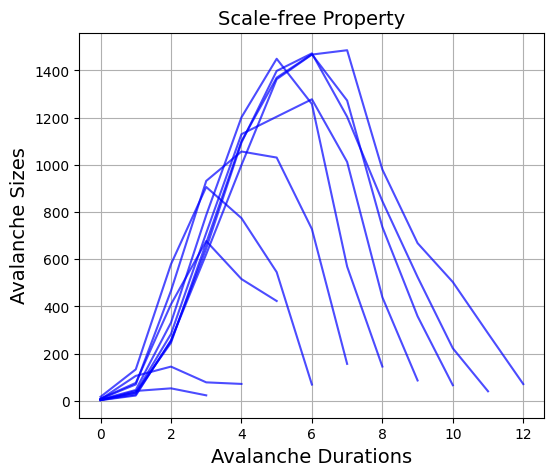

In [4]:
# avalanche size vs. avalanche duration for scale-fee property
df = load_data_csv("data/avalanche_statistics_scalefree.csv")
all_avalanches = df['avalanches'].apply(eval).tolist()
avalanches_by_length = defaultdict(list)
for av in all_avalanches:
    avalanches_by_length[len(av)].append(av)
mean_activities = {length: np.mean(np.array(avs), axis=0) for length, avs in avalanches_by_length.items()}
plt.figure(figsize=(6, 5)) 
plt.title("Scale-free Property", fontsize=14)
plt.xlabel("Avalanche Durations", fontsize=14)
plt.ylabel("Avalanche Sizes", fontsize=14)
plt.grid(True)
for length, mean_activity in mean_activities.items():
    if length < 15 and length > 3:
        plt.plot(range(length), mean_activity, label=f'Duration {length}', color='blue', alpha=0.7)

plt.show()

#### Plot the scalefree with zooming
> Since we dont have enough data(due to limited computation resources), the following rescale figure will look different for every differen run.
> There shall be a rescale formula for x and y. But we dont have enough time to delve into how to get this function.

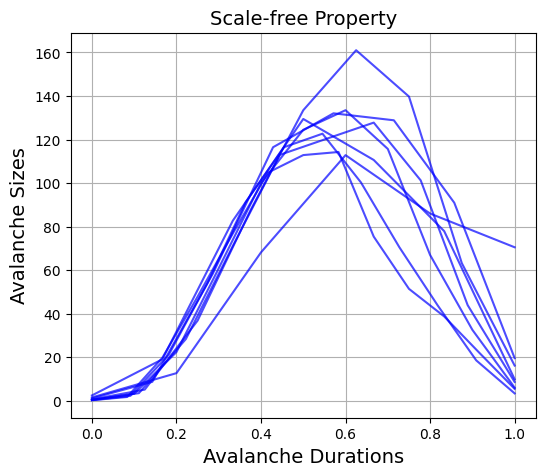

In [8]:
plt.figure(figsize=(6, 5)) 
plt.title("Scale-free Property", fontsize=14)
plt.xlabel("Avalanche Durations", fontsize=14)
plt.ylabel("Avalanche Sizes", fontsize=14)
plt.grid(True)
for length, mean_activity in mean_activities.items():
    if length < 16 and length > 5 :
        scaled_time = [i / (length - 1) for i in range(length)]
        scaled_activity = [activity / ((length) ** (2- 1)) for activity in mean_activity]
        plt.plot(scaled_time, scaled_activity, label=f'Duration {length}', color='blue', alpha=0.7)

plt.show()


### Testing varying parameters to catch the phase transitions

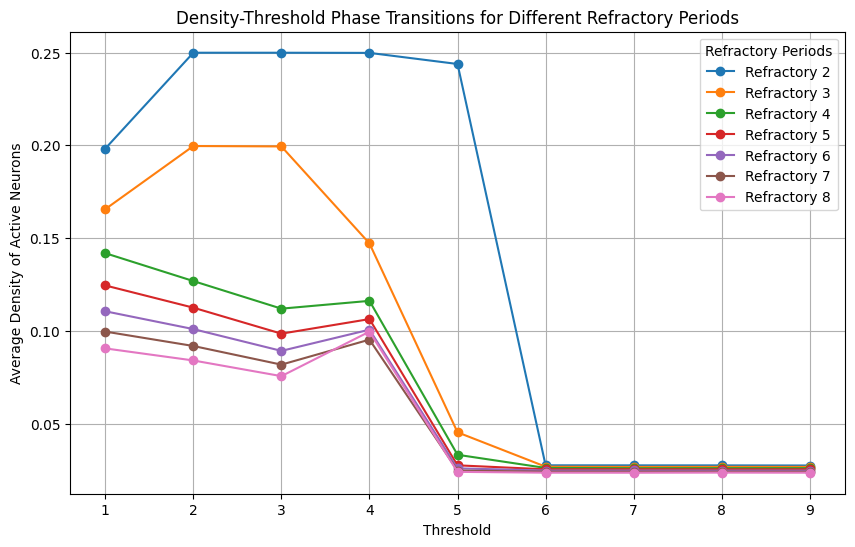

In [21]:
# Average density of active neurons of varying threshold(max_height) with different refractory periods

threshold_values = range(1, 10)
refractory_periods = [2, 3, 4, 5, 6, 7, 8]

plt.figure(figsize=(10, 6))

for refractory_period in refractory_periods:
    average_densities = []

    for threshold in threshold_values:
        file_name = f"data/new_varying_threshold_{threshold}_ref_{refractory_period}.csv"
        data = pd.read_csv(file_name)

        average_density = data["spikes_total"].mean() / (50 * 50)
        average_densities.append(average_density)

    plt.plot(threshold_values, average_densities, marker='o', label=f'Refractory {refractory_period}')

plt.xlabel('Threshold')
plt.ylabel('Average Density of Active Neurons')
plt.title('Density-Threshold Phase Transitions for Different Refractory Periods')

plt.legend(title="Refractory Periods")
plt.grid(True)
plt.show()

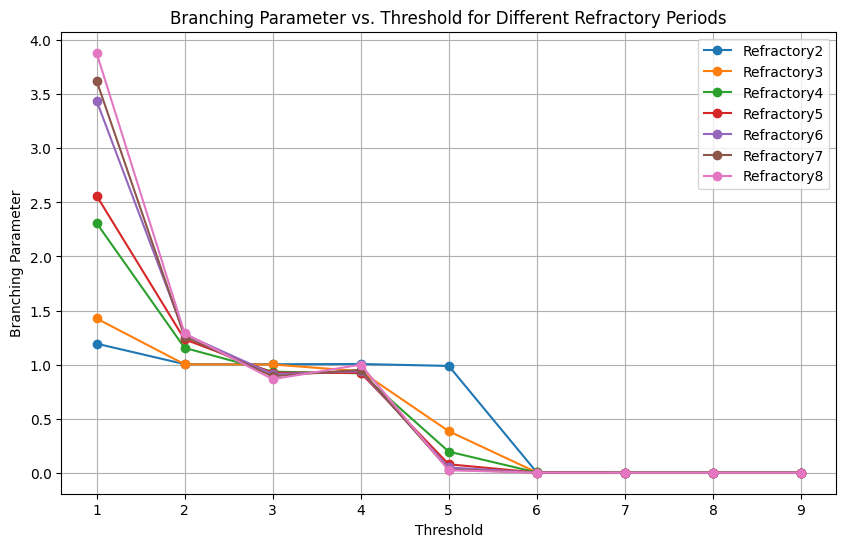

In [22]:
# Branching parameter of varying thresholds at different refractory periods

branching_params_by_ref = {rp: [] for rp in refractory_periods}

for rp in refractory_periods:
    for threshold in threshold_values:
        file_name = f"data/new_varying_threshold_{threshold}_ref_{rp}.csv"
        data = pd.read_csv(file_name)
        sigma= branching_prameter(data)
        branching_params_by_ref[rp].append(sigma)

plt.figure(figsize=(10, 6))
for rp, branching_params in branching_params_by_ref.items():
    plt.plot(threshold_values, branching_params, marker='o', label=f'Refractory{rp}')

plt.xlabel('Threshold')
plt.ylabel('Branching Parameter')
plt.title('Branching Parameter vs. Threshold for Different Refractory Periods')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# table for different combination of threshold and refractory period

refractory_periods = range(1, 8)
heights = range(1, 7)

branching_params_df = pd.DataFrame(index=refractory_periods, columns=heights)

for rp in refractory_periods:
    for h in heights:
        file_name = f'data/ref_{rp}_threshold_{h}.csv'
        if os.path.exists(file_name):
            data = pd.read_csv(file_name)
            sigma = branching_prameter(data)
            branching_params_df.loc[rp, h] = sigma

        else:
            print(f"File {file_name} not found.")

branching_params_df

,1,2,3,4,5,6
1,1.072893,1.048752,1.008726,1.000657,0.995926,0.0005
2,1.185775,1.004562,1.002064,0.999942,0.116711,0.000549
3,1.483476,1.002042,1.000076,0.993312,0.034512,0.000345
4,1.962695,1.111417,1.000494,0.934519,0.023599,0.00035
5,2.70181,1.176271,0.918642,0.943209,0.016417,0.000264
6,3.41466,1.210516,0.907791,0.947883,0.008089,0.000251
7,3.516039,1.209075,0.887735,0.964623,0.006568,0.00027


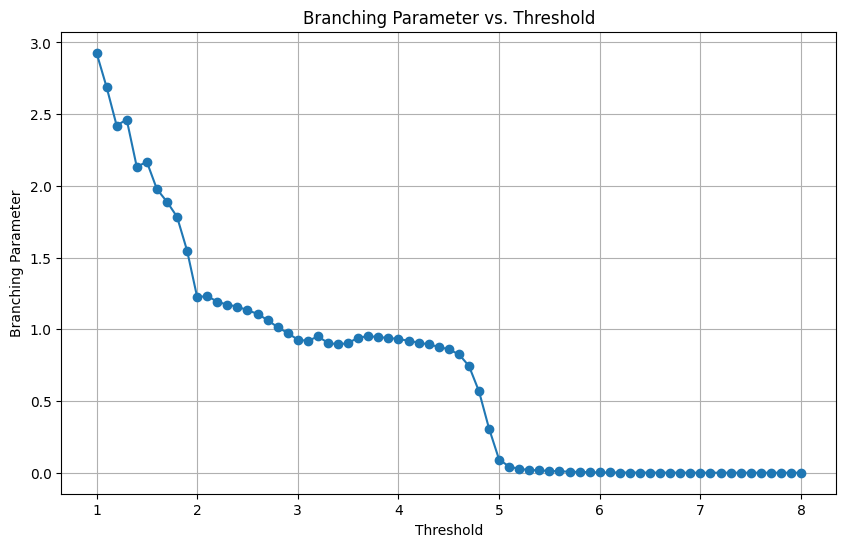

In [24]:
# Branching parameters of continuous theshold values

threshold_values = np.arange(1.0, 8.1, 0.1)
branching_params = []

# Loop through each threshold value, read the CSV file and calculate the branching parameter
for threshold in threshold_values:
    file_name = f"data/new_varying_threshold_{threshold:.1f}.csv"  # Adjust filename pattern as necessary
    data = pd.read_csv(file_name)
    
    # Calculate the branching parameter using the function from data_utils.py
    sigma = branching_prameter(data)
    branching_params.append(sigma)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, branching_params, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Branching Parameter')
plt.title('Branching Parameter vs. Threshold')
plt.grid(True)
plt.show()